# Kurze Anmerkung zu Beginn

#### Im folgenden Notebook wird anhand des Ziels der Detektion und Extraktion von einzelnen Spielkarten in einer Aufnahme des Kartenspieles "Set!" gezeigt, wie eine Bildverarbeitungs-Prozesskette aussehen kann.

OpenCV bietet sehr viele effiziente Funktionen für Bildverarbeitung und Mustererkennung. Einzelne dieser Funktionen werden hier beispielhaft verwendet.

In [1]:
%matplotlib inline

# Laden der verwendeten Bibliotheken
import   numpy  as np   
import   matplotlib                 # https://matplotlib.org/3.1.1/tutorials/index.html
import   matplotlib.pyplot as plt   # https://matplotlib.org/tutorials/introductory/pyplot.html
import cv2

Für die vereinfachte Anzeige von Bildern definieren wir die Funktion imshow(), die als Parameter ein Grauwertbild oder ein BGR-Farbbild erwartet und dieses anzeigt. Somit muss nicht jedes mal manuell die cmap (bei Grauwertbildern) gesetzt oder die Farbraumkonvertierung (von BGR-OpenCV-Bildern zu RGB-Bildern für die Anzeige mit MatPlotLib) durchgeführt werden. 

In [2]:
def imshow(img):
    shape=img.shape
    plt.figure(figsize = (10,10))
    if(len(shape)==2):
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img[:,:,::-1])
    plt.axis(False)
    plt.show()        

Falls ein Bild nicht den vollen Dynamikumfang ausnutzt, macht es für die Anzeige oft Sinn, das Helligkeitsminimum auf 0 und das Helligkeitsmaximum auf 1 zu setzen (Schwarz- und Weißabgleich). Hierzu definieren wir eine Hilfsfunktion fullContrast(). 

In [3]:
def fullContrast(img):
    min=np.min(img)
    max=np.max(img)
    return (img-min).astype(float)/(max-min)

Ziel: Finde und extrahiere in der folgenden Aufnahme von Set!-Karten die einzelnen Karten.

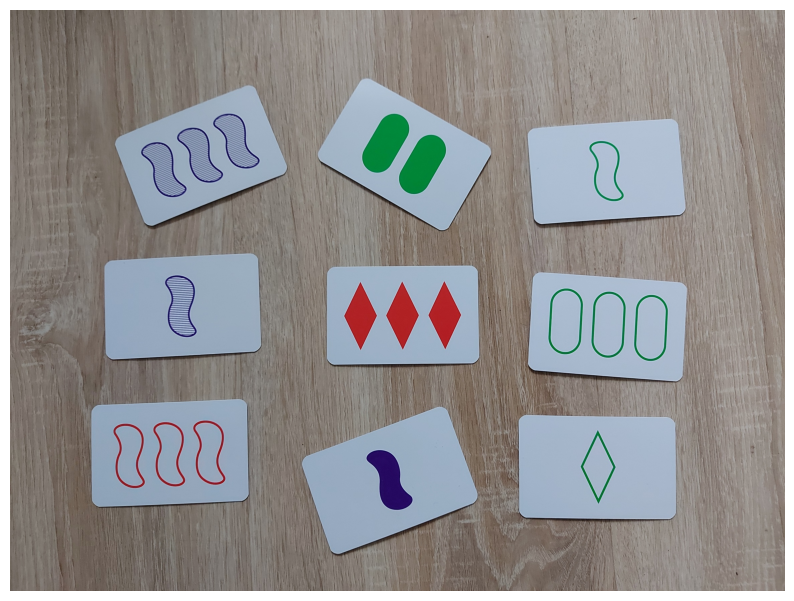

In [4]:
# Bild laden mit OpenCV
img = cv2.imread("set/set5.jpg")
imshow(img)

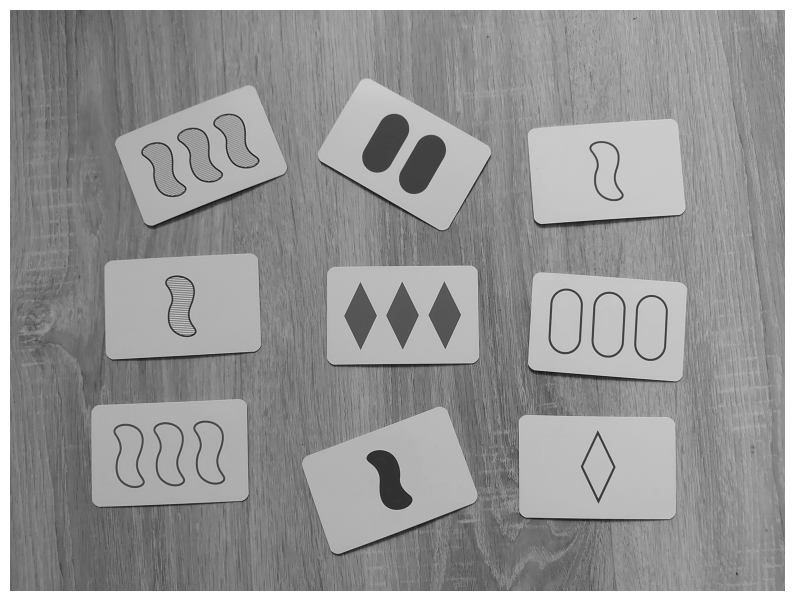

In [5]:
gray=np.mean(img,axis=2).astype(np.uint8)
imshow(gray)

Wichtig: Es gibt verschiedene Methoden zur Konvertierung eines Farbbildes in Graustufen. Wenn es um die messtechnische Kombination der drei Kanäle geht, macht es oft Sinn, den arithmetischen Mittelwert zu bilden (siehe oben). Wenn es darum geht, ein Graustufenbild für die Anzeige zu erhalten (entsprechend der Empfindlichkeit des menschlichen Auges), so müssen die Kanäle unterschiedlich stark gewichtet werden: 

gray_pixel = 0.114 * blue_pixel + 0.299 * red_pixel + 0.587 * green_pixel

Dies geschieht z.B. mit der FUnktion cv2.cvtColor(.,.) mit dem Parameter cv2.COLOR_BGR2GRAY:

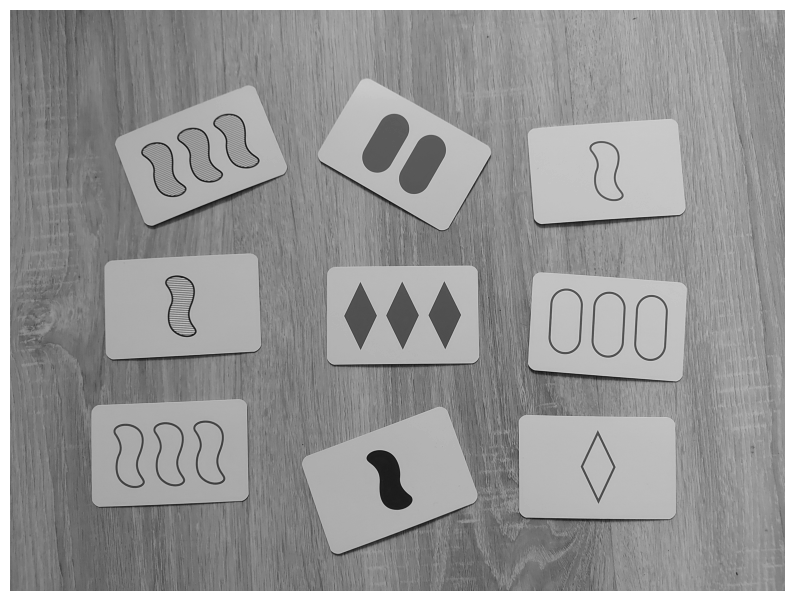

In [6]:
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)

Es zeigt sich, dass die hellen Karten nicht einfach mit einer schwellenwertbasierten Binarisierung vom Hintergrund getrennt werden können:

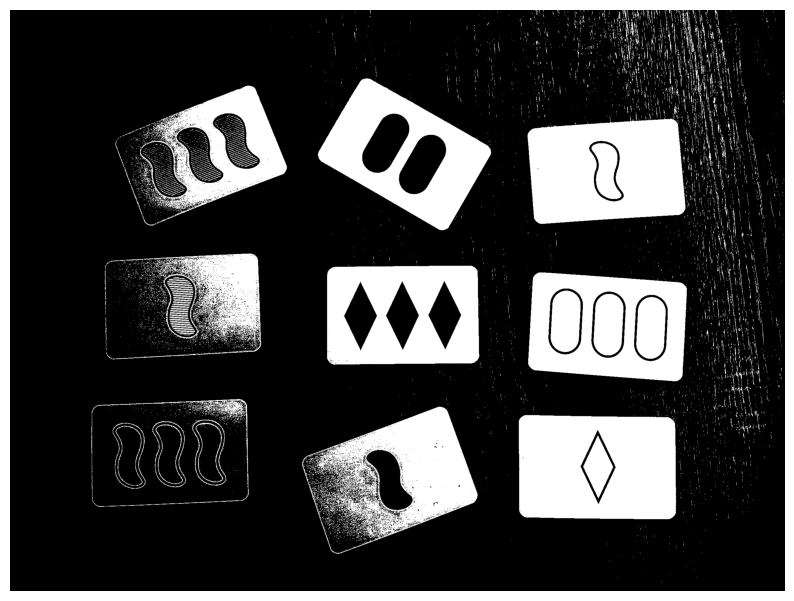

In [7]:
imshow(gray>167)

Es fällt aber auf, dass der Bildhintergrund deutlich inhomogener ist als die weißen Karten selbst. Dies kann für das Finden der Karten ausgenutzt werden. 

Der Morphologische Gradient kann verwendet werden, um homogene von inhomogenen Bereichen zu unterscheiden:

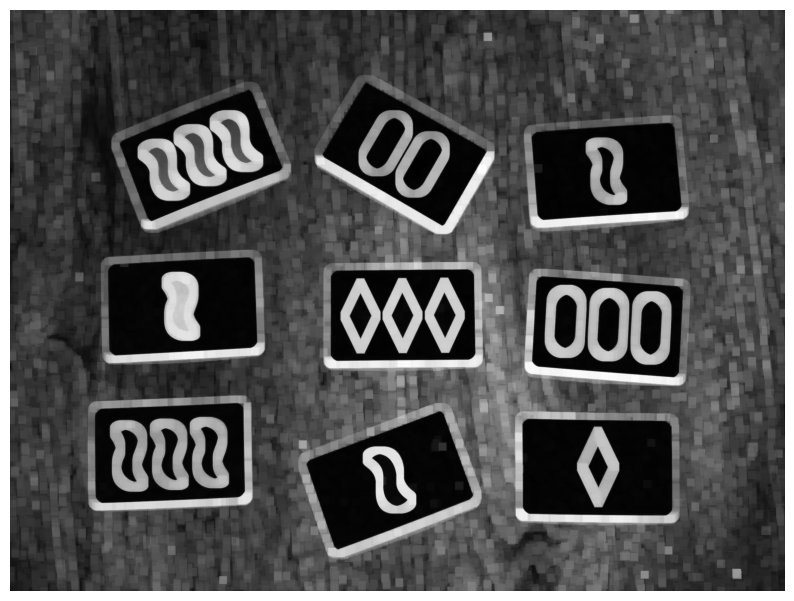

In [8]:
morphgradient=cv2.dilate(gray,np.ones((23,23)))-cv2.erode(gray,np.ones((23,23)))
imshow(morphgradient)

Hier reicht nun eine einfache Schwellenwertfunktion, um die weißen Bereiche der Karten als einzelne Regionen zu erhalten. Aber es gibt noch immer ungewollte Regionen im Hintergrund.

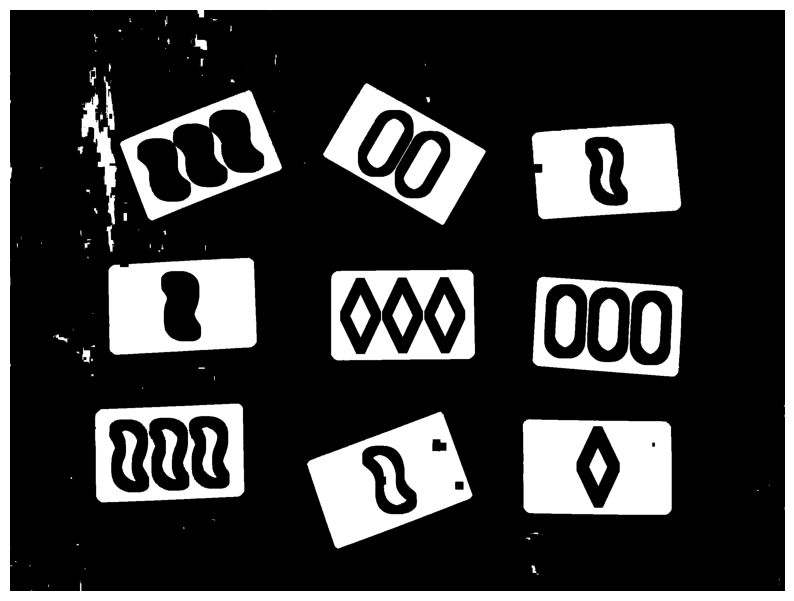

In [9]:
regions=(morphgradient<20).astype(np.uint8)
imshow(fullContrast(regions))

Nun kann man z.B. die einzelnen zusammenhängenden Regionen in dem binarisierten Bild als Zusammenhangskomponenten ermitteln. Die OpenCV-Funktion connectedComponentsWithStats() liefert für jede Komponente neben der Bounding-Box auch die Fläche (in Pixeln) und den Schwerpunkt:

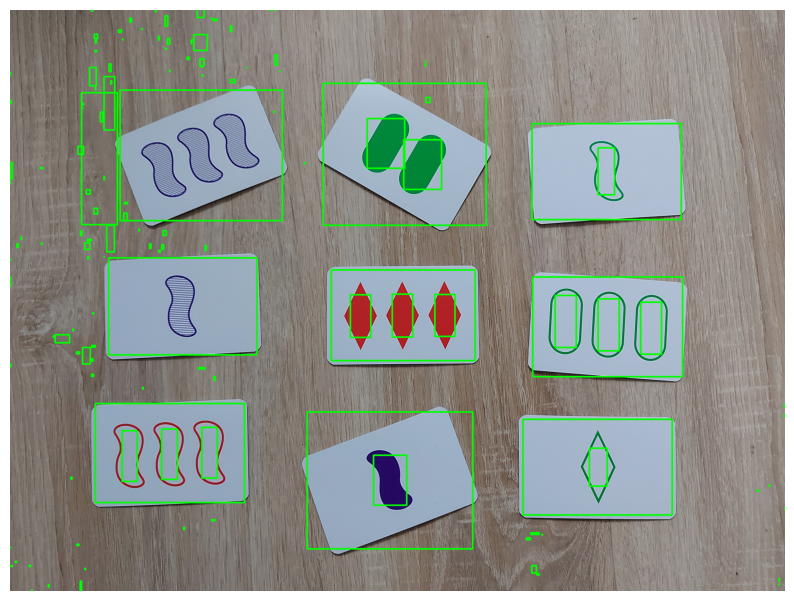

In [10]:
(numLabels, labels, stats, centroids) = cv2.connectedComponentsWithStats(regions, 4, cv2.CV_32S)
boundingboxview=img.copy()
for i in range(1, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    cv2.rectangle(boundingboxview,(x,y),(x+w,y+h),(0,255,0),3)
    mask=(labels==i).astype(np.uint8)
imshow(boundingboxview)

Das bild "labels" enthält die Labels der gefundenen Regionen als Pixelwerte. Jede Region hat also einen anderen eigenen Grauwert.

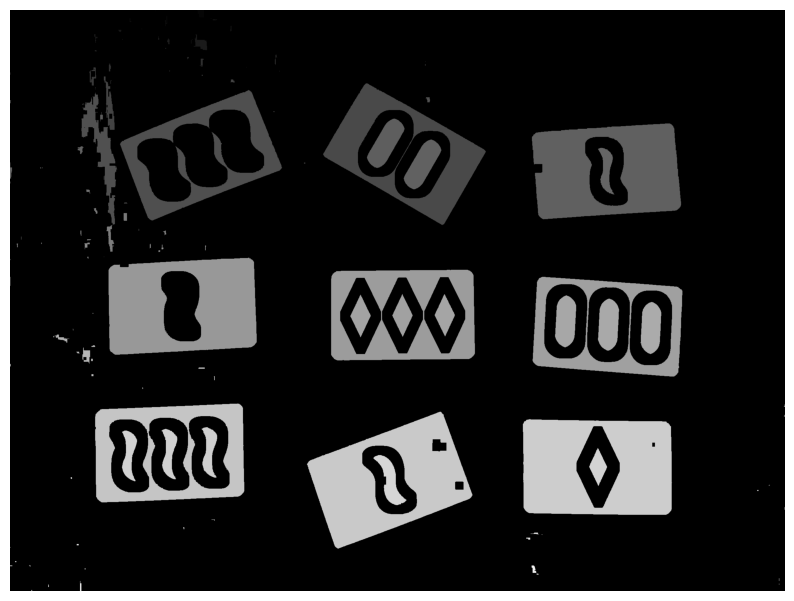

In [11]:
imshow(labels)

Für die Extraktion der Karten nützen die Bounding-Box und der Schwerpunkt nicht viel. Mehr kann man mit den Regionenkonturen anfangen. Dies sind Ketten von Pixeln entlang des Randes jeder Region.

In [12]:
# Extrahieren aller äußeren Konturen als Liste von Pixelketten
contours,_ = cv2.findContours(regions,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(contours))

122


In [13]:
contour=contours[62]
print(contour.shape)
print(contour)

(18, 1, 2)
[[[340 579]]

 [[341 579]]

 [[342 579]]

 [[343 579]]

 [[344 579]]

 [[345 579]]

 [[346 579]]

 [[347 579]]

 [[348 579]]

 [[349 579]]

 [[348 579]]

 [[347 579]]

 [[346 579]]

 [[345 579]]

 [[344 579]]

 [[343 579]]

 [[342 579]]

 [[341 579]]]


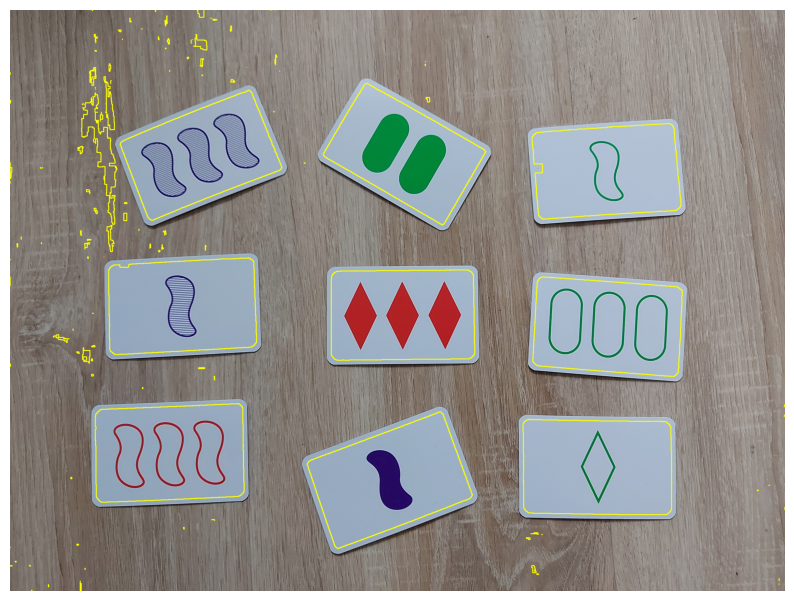

In [14]:
annotated=img.copy()

for contour in contours: 
    cv2.drawContours(annotated, [contour], 0, (0,255,255), 2)
    
imshow(annotated)

Die einzelnen Konturen können sehr komplex geformt sein. Wir interessieren uns für ungefähr rechteckige Konturen. Um solche zu finden bietet OpenCV einige Funktionen.
Da auch bei den gewollten Konturen der Karten teilweise kleine Einbuchtungen auftreten, ersetzen wir zunächst jede Kontur durch ihre konvexe Hülle:

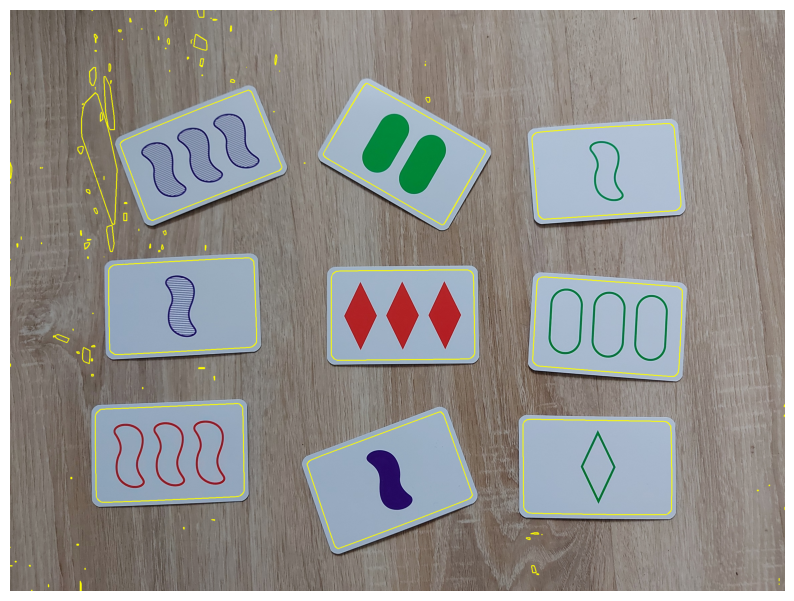

In [15]:
annotated=img.copy()

for contour in contours:
    
    convex=cv2.convexHull(contour) 

    cv2.drawContours(annotated, [convex], 0, (0,255,255), 2)

imshow(annotated)

Nun vereinfachen wir die Konturen zu Polygonzügen. Dabei wird bei jeder Kontur ein Randpixel immer dann aus der Pixelfolge entfernt, wennder Verlauf der so entstehenden neuen Kontur weniger als 5% der gesamten Kantenlänge von dem vorherigen Verlauf abweicht.

Damit sollte jede Randkontur einer der Karten nur noch aus vier Eckpunkten bestehen.

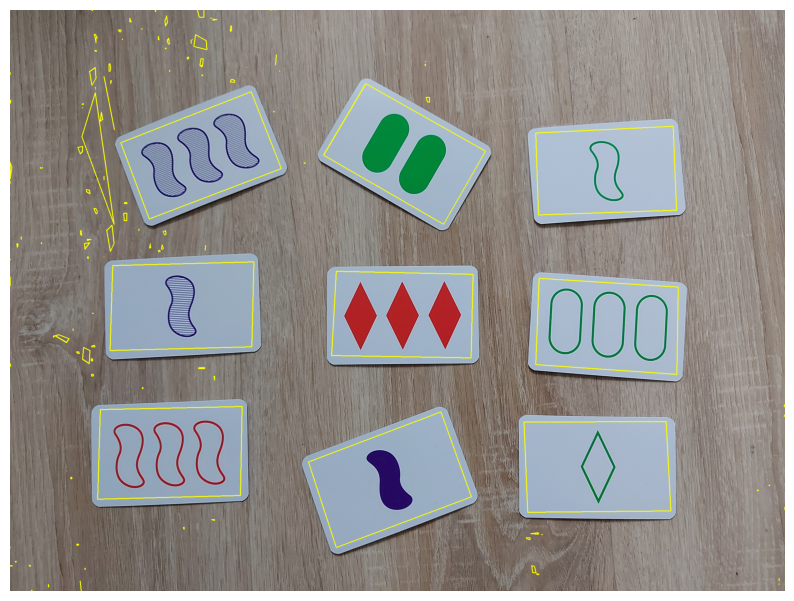

In [16]:
annotated=img.copy()

for contour in contours:
    convex=cv2.convexHull(contour) 

    arcLength=cv2.arcLength(convex,True) # Konturlänge ermitteln
    approx=cv2.approxPolyDP(convex,0.05*arcLength,True) # Kontur zu Polygonzug vereinfachen

    cv2.drawContours(annotated, [approx], 0, (0,255,255), 2)
imshow(annotated)

Nun können wir die Konturen nach einfachen Kriterien filtern, um ungewollte Konturen zu entfernen. Wir entfernen 
- jede Kontur, die kein Viereck ist,
- jedes Viereck, welches nicht einem Parallelogramm ähnelt (bei dem also die gegenüberliegenden Kanten nicht ungefähr gleich lang sind),
- jedes Parallelogramm, dessen kurze Seite kürzer als 100 Pixel ist und dessen lange Seite länger als 600 Pixel ist,
- jedes Parallelogramm, dessen Seitenverhältnis nicht zwischen 1,2 und 2,2 liegt.

In [17]:
# Liste zum Speichern der Rechtecke zu den gefundenen Karten
card_quadrangles=[]


for contour in contours:

    convex=cv2.convexHull(contour) # Konvexe Hülle bilden

    arcLength=cv2.arcLength(convex,True) # Konturlänge ermitteln
    
    approx=cv2.approxPolyDP(convex,0.05*arcLength,True) # Kontur zu Polygonzug vereinfachen

    if(len(approx)!=4): # Viereckstest
        continue
        
    # Alle vier Kantenlängen ermitteln. "cv2.norm" berechnet per Default die L2-Norm, also den Euklidischen Abstand
    l0=cv2.norm(approx[0],approx[1]) 
    l1=cv2.norm(approx[1],approx[2])
    l2=cv2.norm(approx[2],approx[3])
    l3=cv2.norm(approx[3],approx[0])
    
    # Mittlere Breite und Höhe bestimmen (Annahme: Parallelogramm)
    w,h = (l0+l2)/2, (l1+l3)/2
    
    if(abs(l0-l2)>0.15*w) | (abs(l1-l3)>0.15*h): # Parallelogrammtest
        continue
    
    # Wenn Breite>Höhe: um 90° drehen (eine Karte ist höher als breit)
    if(w>h):
        w,h = h,w
        approx=np.roll(approx,1,axis=0)

    if(w  <100) | (h > 600): # Größentest
        continue

    if(h > 2.2*w) | (h<1.2 * w):   # Seitenverhältnistest
        continue

    card_quadrangles.append(np.squeeze(approx))

print(len(card_quadrangles))

9


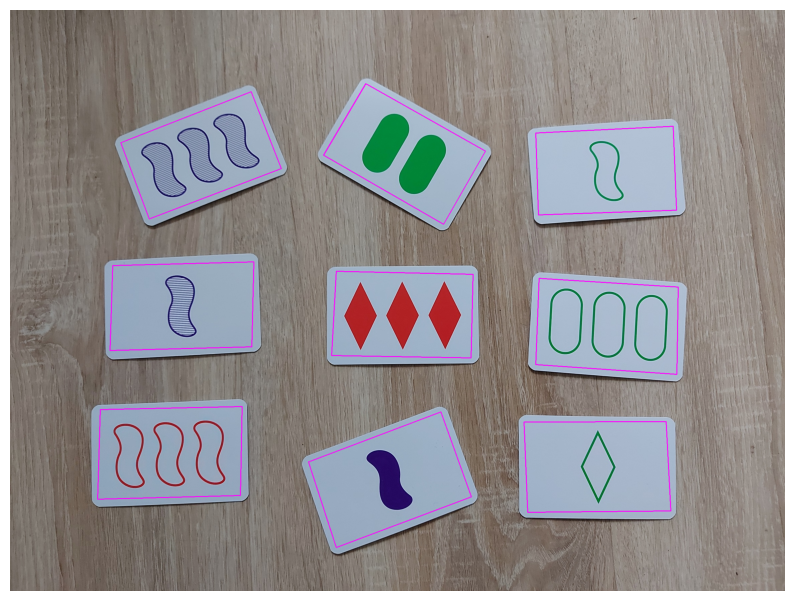

In [18]:
annotated=img.copy()
for quad in card_quadrangles:
    cv2.drawContours(annotated, [quad], 0, (255,0,255), 2)
imshow(annotated)

Nun können wir die gefundenen Rechteckpunkte der übrigen Konturen nutzen um die entsprechenden Bildausschnitte jeweils in ein Bild der festen Größe 300x500 zu warpen. Eine hier nötige perspektivische Transformation benötigt genau vier Punkte.

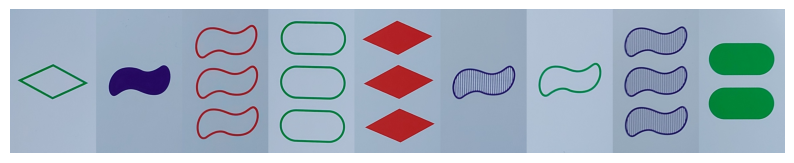

In [19]:
result = None
cardArray = []

for card in card_quadrangles:
    
    destRect = np.float32([[0,0],[300,0],[300,500],[0,500]])

    transformMatrix = cv2.getPerspectiveTransform(card.astype(np.float32), destRect)

    cardImage = cv2.warpPerspective(img,transformMatrix,(300,500))
    cardArray.append(cardImage)

    if result is None:
        
        result=cardImage.copy()
    else:
        result=np.concatenate([result,cardImage],axis=1)   

imshow(result)

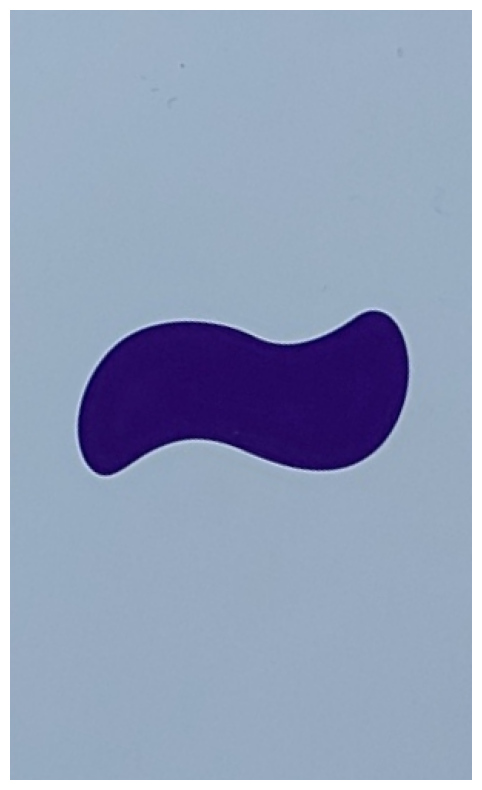

In [20]:
imshow(cardArray[1])

Now we want to find out what is the color of the card

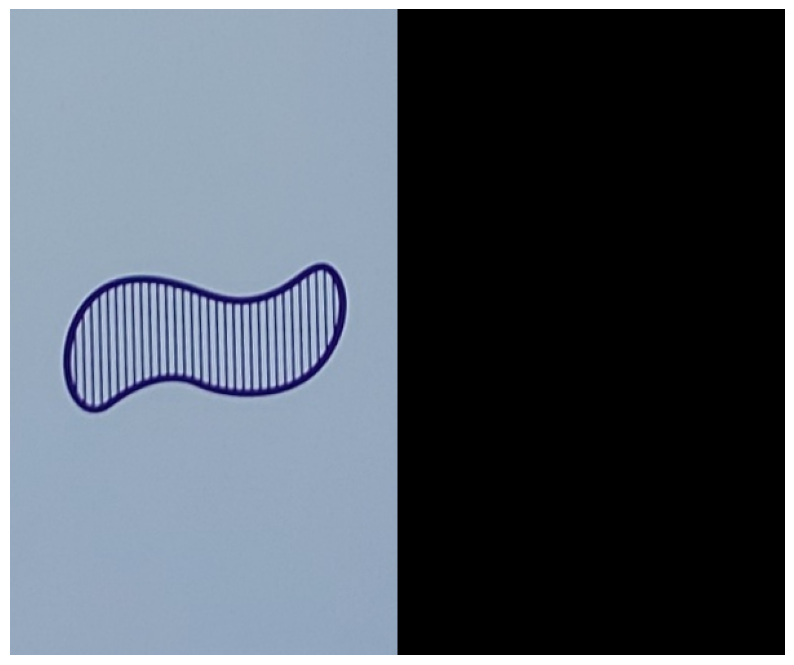

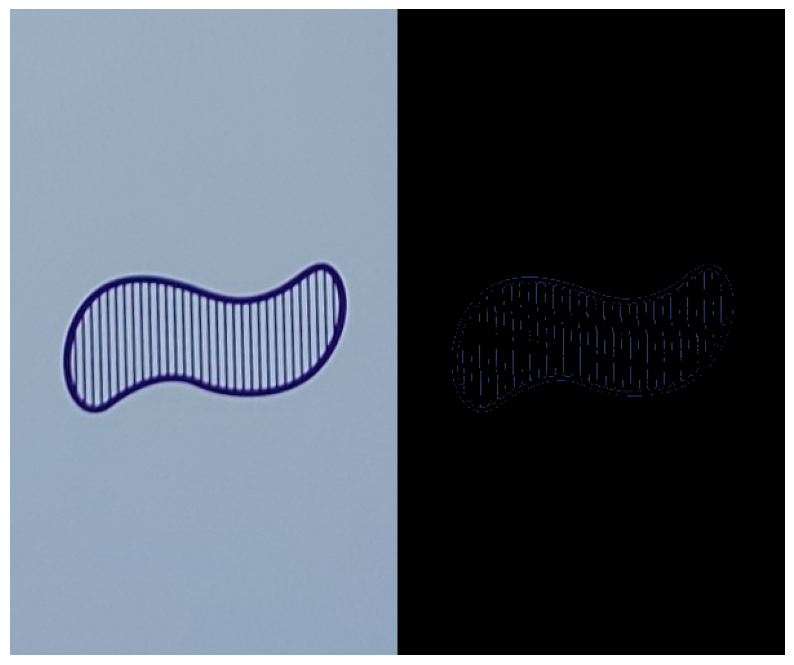

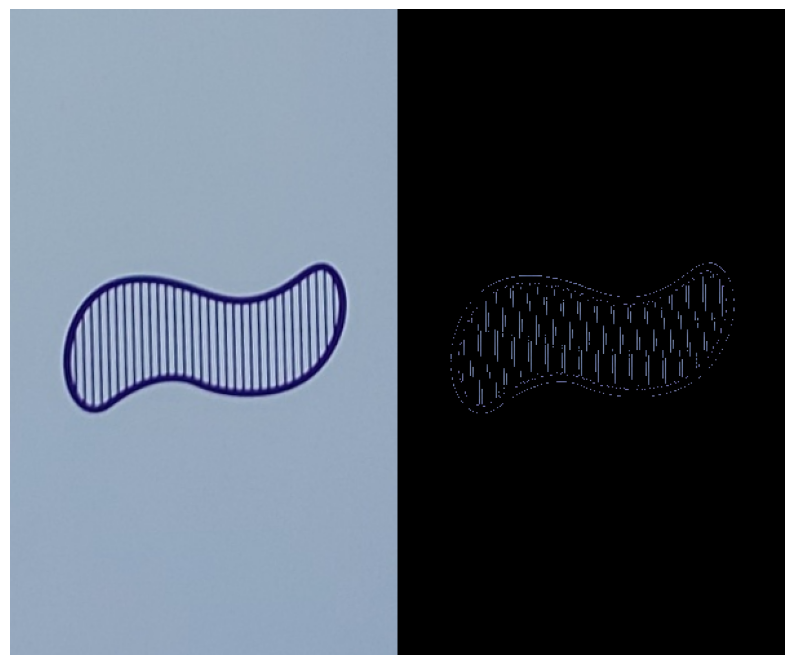

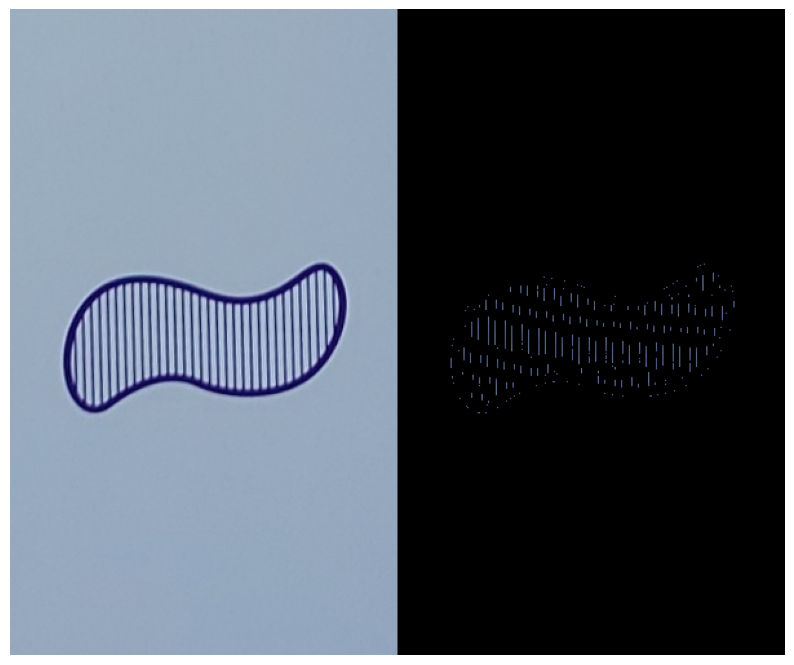

In [23]:
image = cardArray[5]
def showBoundarie():
	# define the list of boundaries
	boundaries = [
		([17, 15, 100], [50, 56, 200]),
		([86, 31, 4], [220, 88, 50]),
		([29, 98, 66], [191, 239, 118]),
		([103, 86, 65], [145, 133, 128])
	]

	# loop over the boundaries
	for (lower, upper) in boundaries:
		# create NumPy arrays from the boundaries
		lower = np.array(lower, dtype = "uint8")
		upper = np.array(upper, dtype = "uint8")
		# find the colors within the specified boundaries and apply
		# the mask
		mask = cv2.inRange(image, lower, upper)
		output = cv2.bitwise_and(image, image, mask = mask)
		# show the images
		imshow(np.hstack([image, output]))
		
showBoundarie()

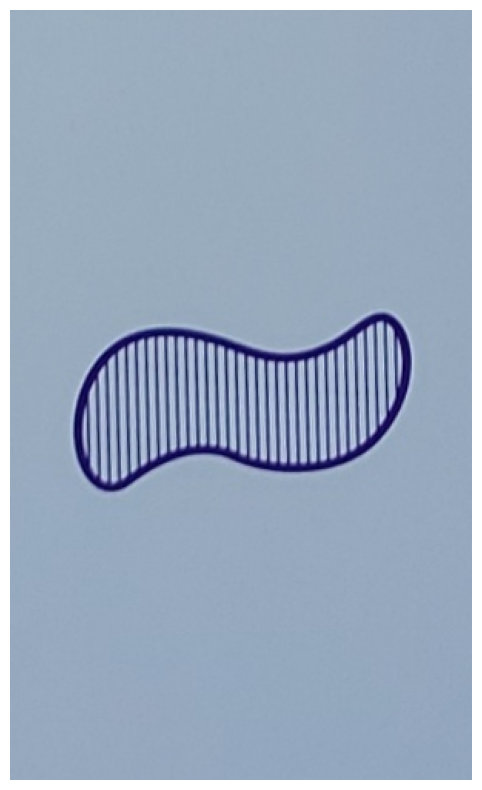

Durchschnittliche Farbe der Zeichnung für Rot: (0, 0, 0)
Durchschnittliche Farbe der Zeichnung für Grün: (0, 0, 0)
Durchschnittliche Farbe der Zeichnung für Blau: (0, 0, 0)


In [22]:
imshow(image)
# Extrahieren Sie den Bereich der Zeichnung in der Mitte des Bildes
h, w, _ = image.shape
drawing = image

# Definieren Sie die Farben Rot, Grün und Blau
colors = {"Rot": (0, 0, 255), "Grün": (0, 255, 0), "Blau": (255, 0, 0)}

# Loop über die Farben
for color_name, color in colors.items():
    # Erstellen Sie eine Maske, die die Pixel in dem gewünschten Farbbereich markiert
    lower_color = np.array(color) - np.array([20, 20, 20])
    upper_color = np.array(color) + np.array([20, 20, 20])
    mask = cv2.inRange(drawing, lower_color, upper_color)

    # Berechnen Sie den Durchschnitt der Farben in dem markierten Bereich
    mean_color = cv2.mean(drawing, mask=mask)

    # Geben Sie die durchschnittliche Farbe als BGR-Tupel aus
    print(f"Durchschnittliche Farbe der Zeichnung für {color_name}: {tuple(round(c) for c in mean_color[:3])}")
